# Load Library & Preprocess Data

In [1]:
import random, os, math
from datetime import datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import cv2
from tqdm import tqdm
from math import floor
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.backend as K
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import *

import posenet

import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"

### Set Seed

In [2]:
SEED = 42

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

# Hyperparameter 

In [3]:
learning_rate = 1e-4
optimizer = tf.keras.optimizers.Adam(learning_rate)

batch_size = 8
mode = 'mobilenet_v1'
EPOCHS = 100

alpha = .25
gamma = 2

ckpt_path = f'20200814_alpha-90'

In [4]:
TRAIN_ROOT_PATH = f'../../Datasets/mpii_human_pose_v1'
pd.set_option('display.max_columns', None)
df_ = pd.read_csv(TRAIN_ROOT_PATH + f'/mpii_human_pose_v1_u12_2/mpii_dataset.csv')
df_ = df_.iloc[:, 1:-3]

df_ = df_.iloc[:, [0, 13, 14, 5, 6, 3, 4, 1, 2, 7, 8, 9, 10, 11, 12,
                  15, 16, 17, 18, 19, 20, 27, 28, 29, 30, 31, 32, 25, 26, 23, 24, 21, 22]]

spine = (np.array(df_.iloc[:, [15, 16]]) +  np.array(df_.iloc[:, [1, 2]])) // 2

df_ = pd.concat([df_, pd.DataFrame(spine)], axis=1)
df = df_.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14,
                 33, 34, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32]]
df.rename(columns={0:'spine_X', 1:'spine_Y'}, inplace=True)

df = df.drop(df[df.iloc[:, 1] == -1].index)
df = df.drop(df[df.iloc[:, 17] == -1].index)

df.iloc[:, 0] = TRAIN_ROOT_PATH + f'/images/' + df.iloc[:, 0]
print(len(df))
df.head()

16816


,NAME,pelvis_X,pelvis_Y,r hip_X,r hip_Y,r knee_X,r knee_Y,r ankle_X,r ankle_Y,l hip_X,l hip_Y,l knee_X,l knee_Y,l ankle_X,l ankle_Y,spine_X,spine_Y,thorax_X,thorax_Y,upper neck_X,upper neck_Y,head top_X,head top_Y,l shoulder_X,l shoulder_Y,l elbow_X,l elbow_Y,l wrist_X,l wrist_Y,r shoulder_X,r shoulder_Y,r elbow_X,r elbow_Y,r wrist_X,r wrist_Y
0,../../Datasets/mpii_human_pose_v1/images/01560...,610,187,573,185,616,269,620,394,647,188,661,221,656,231,628,181,647,176,637.0201,189.8183,695.9799,108.1817,692,185,693,240,688,313,601,167,553,161,606,217
1,../../Datasets/mpii_human_pose_v1/images/01559...,763,568,806,543,-1,-1,-1,-1,720,593,-1,-1,-1,-1,723,429,683,290,682.0000,256.0000,676.0000,68.0000,719,299,711,516,545,466,647,281,555,410,563,296
2,../../Datasets/mpii_human_pose_v1/images/00580...,974,446,908,438,816,510,804,711,1040,454,906,528,883,707,979,349,985,253,982.7591,235.9694,962.2409,80.0306,1067,253,1167,353,1142,478,902,253,798,340,869,214
3,../../Datasets/mpii_human_pose_v1/images/08661...,248,341,201,340,305,375,301,461,294,342,335,370,331,455,263,302,279,263,277.0210,268.7786,305.9790,184.2214,314,264,327,320,362,346,244,261,260,335,328,354
4,../../Datasets/mpii_human_pose_v1/images/06011...,904,237,865,248,896,318,980,322,943,226,948,290,881,349,881,186,858,135,871.1877,180.4244,835.8123,58.5756,923,123,995,163,961,223,792,147,754,247,772,294


### Split train & test Data 

In [5]:
train_df, validation_df = train_test_split(df, test_size=0.3, random_state=SEED)

# Utils 

In [6]:
def normalize_image(image):
    mean = [0.40789655, 0.44719303, 0.47026116]
    std = [0.2886383, 0.27408165, 0.27809834]
    return ((np.float32(image) / 255.) - mean) / std

def heatmap(keypoints, input_size, output_width=32, output_height=32, sigma=1):
    
    heatmap_result = np.zeros((output_width, output_height, 17))
    offset_result = np.zeros((output_width, output_height, 34))
    displacement_fwd_result = np.zeros((output_width, output_height, 32))
    displacement_bwd_result = np.zeros((output_width, output_height, 32))
    resize_rate_w = output_width / input_size[1]
    resize_rate_h = output_height / input_size[0]
    
    def get_coords(keypoints):
        keypoints = keypoints.reshape(17, 2)
        x_radius = (np.max(keypoints[:,0]) - np.min(keypoints[:,0])) / 8
        y_radius = (np.max(keypoints[:,1]) - np.min(keypoints[:,1])) / 8
        return keypoints, x_radius, y_radius
    
    def get_heatmap(p_x, p_y, sigma):
        X1 = np.linspace(1, output_width, output_height)
        Y1 = np.linspace(1, output_width, output_height)
        [X, Y] = np.meshgrid(X1, Y1)
        X = X - floor(p_x)
        Y = Y - floor(p_y)
        D2 = X * X + Y * Y
        E2 = 2.0 * sigma ** 2
        Exponent = D2 / E2
        heatmap = np.exp(-Exponent)
        heatmap = heatmap[:, :, np.newaxis]
        return heatmap
    
    def get_offset(x, y, x_radius, y_radius):
        x_radius = np.max([2, floor(x_radius * resize_rate_h)])
        y_radius = np.max([2, floor(y_radius * resize_rate_w)])
        offset_x = np.zeros((output_width, output_height))
        offset_y = np.zeros((output_width, output_height))
        p_x = floor(x * resize_rate_w)
        p_y = floor(y * resize_rate_h)
        for idx in range(output_width):
            # x - (p_x / resize_rate_w) + (1 / resize_rate_w) * (idx - p_x)
            # y - (p_y / resize_rate_h) + (1 / resize_rate_h) * (idx - p_y)
            if p_y - y_radius <= idx <= p_y + y_radius:
                offset_x[idx,p_x - x_radius:p_x + x_radius] = y - idx / resize_rate_h
            if p_x - x_radius <= idx <= p_x + x_radius:
                offset_y[p_y - y_radius:p_y + y_radius,idx] = x - idx / resize_rate_w
        return offset_x, offset_y
    
    keypoints, x_radius, y_radius = get_coords(keypoints)
    
    for idx, keypoint in enumerate(keypoints):
        if -1 in keypoint: continue
        heatmap = get_heatmap(keypoint[0] * resize_rate_w,
                              keypoint[1] * resize_rate_h,
                              sigma)
        heatmap_result[:,:,idx] = np.maximum(heatmap_result[:,:,idx], heatmap[:,:,0])
        
        offset_x, offset_y = get_offset(keypoint[0], keypoint[1], x_radius, y_radius)
        offset_result[:,:,idx] = offset_x
        offset_result[:,:,17 + idx] = offset_y
    
    return heatmap_result, offset_result, displacement_fwd_result, displacement_bwd_result

In [7]:
def draw_heatmap(batch, heatmap_result, offset_result, displacement_fwd_result=None, displacement_bwd_result=None):
        
    plt.figure(figsize=(10, 30))

    ### Heatmap
    for idx in range(17):
        plt.subplot(12,5,idx+1)
        plt.imshow(heatmap_result[batch][:,:,idx])
        plt.title(idx)

    
    ### Offset
    for idx in range(17):
        plt.subplot(12,5,idx+1+20)
        plt.imshow(offset_result[batch][:,:,idx])
        plt.colorbar()
        plt.title(idx)
        plt.subplot(12,5,idx+18+20)
        plt.imshow(offset_result[batch][:,:,17+idx])
        plt.colorbar()
        plt.title(17+idx)
        plt.show

# Datagenerator 

In [8]:
y_col = ['l ankle_X', 'l ankle_Y', 'r knee_X', 'r knee_Y', 'r hip_X',
       'r hip_Y', 'pelvis_X', 'pelvis_Y', 'r ankle_X', 'r ankle_Y', 'l hip_X',
       'l hip_Y', 'l knee_X', 'l knee_Y', 'spine_X', 'spine_Y', 'thorax_X',
       'thorax_Y', 'upper neck_X', 'upper neck_Y', 'head top_X', 'head top_Y',
       'r shoulder_X', 'r shoulder_Y', 'r elbow_X', 'r elbow_Y', 'r wrist_X',
       'r wrist_Y', 'l wrist_X', 'l wrist_Y', 'l elbow_X', 'l elbow_Y',
       'l shoulder_X', 'l shoulder_Y']

train_datagen = ImageDataGenerator(
    rescale=1./255.,
)
validation_datagen = ImageDataGenerator(
    rescale=1./255.,
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='NAME',
    y_col=y_col,
    target_size=(256, 256),
    batch_size=batch_size,
    class_mode='multi_output',
    shuffle=True,

)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    x_col='NAME',
    y_col=y_col,
    traget_size=(256, 256),
    batch_size=batch_size,
    class_mode='multi_output',
)

Found 11771 validated image filenames.
Found 5045 validated image filenames.


# Build Model

In [9]:
class PoseNet(tf.keras.Model):
    def __init__(self):
        super(PoseNet, self).__init__()
        self.conv_init = Conv2D(32, 3, 1)
        
        self.bn1 = BatchNormalization()
        self.conv1 = Conv2D(64, 3 ,1)
        self.bn2 = BatchNormalization()
        self.conv2 = Conv2D(96, 3 ,1)
        self.bn3 = BatchNormalization()
        self.conv3 = Conv2D(128, 3 ,1)
        self.bn4 = BatchNormalization()
        self.conv4 = Conv2D(256, 3 ,1)
        self.bn5 = BatchNormalization()
        self.conv5 = Conv2D(512, 3 ,1)
        
        self.GlobalPool = GlobalAveragePooling2D()
        self.dense1 = Dense(512)
        self.dense2 = Dense(34)
        
    def call(self, x):
        x = self.conv_init(x)
        
        x = self.bn1(x)
        x = tf.nn.leaky_relu(x)
        x = self.conv1(x)
        x = self.bn2(x)
        x = tf.nn.leaky_relu(x)
        x = self.conv2(x)
        x = self.bn3(x)
        x = tf.nn.leaky_relu(x)
        x = self.conv3(x)
        x = self.bn4(x)
        x = tf.nn.leaky_relu(x)
        x = self.conv4(x)
        x = self.bn5(x)
        x = tf.nn.leaky_relu(x)
        x = self.conv5(x)
        
        x = self.GlobalPool(x)
        x = self.dense1(x)
        x = tf.nn.relu(x)
        x = self.dense2(x)
        
        return x

In [10]:
with tf.device('/device:GPU:1'):
    model = PoseNet()
    model.compile(
        optimizer = optimizer,
        loss = tf.keras.losses.MeanAbsoluteError(),
    )

### Visualization 

In [11]:
img, regr = train_generator.__getitem__(1)
result = model(img)
# draw_heatmap(bs-1, *regr)

# Training 

In [12]:
# Learningrate scheduler
def scheduler(epoch):
    if epoch < 10: return 1e-4
    else: return (1e-4) * math.exp(0.1 * (10 - epoch))
learning_rate_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=1)

# Checkpoint
ckpt_dir = f'chechpoints'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    ckpt_dir,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
)

callbacks = [learning_rate_scheduler, checkpoint]

In [ ]:
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    epochs = EPOCHS,
    callbacks = callbacks,
    use_multiprocessing = False,
)


Epoch 00001: LearningRateScheduler reducing learning rate to 0.0001.
Epoch 1/100
  99/1472 [=>............................] - ETA: 7:51 - loss: 463.1522

# History 

In [ ]:
fig, loss_ax = plt.subplots()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

best = min(history.history['val_loss'])
plt.title(f'Best Loss : {best}')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

loss_ax.legend(loc='lower left')

plt.show()

# Inference

In [16]:
base_model = posenet.load_model(mode)
inputs = tf.keras.Input(shape=(256,256,3))
outputs = base_model(inputs)
inf_model = tf.keras.Model(inputs=inputs, outputs=outputs)
inf_model.load_weights(f'./checkpoints/{ckpt_path}.hdf5')

In [17]:
inf_gen = DataGenerator(
    list_IDs = validation_df.index,
    df = df,
    batch_size = 1,
    shuffle = False,
    image_paths = validation_df['NAME'],
    mode = 'fit',
)

In [18]:
img, regr = inf_gen.__getitem__(1)
result = inf_model(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


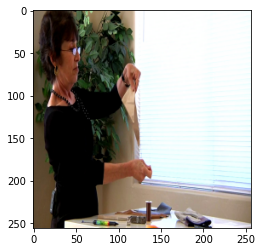

In [19]:
plt.imshow(img[0])
plt.show()

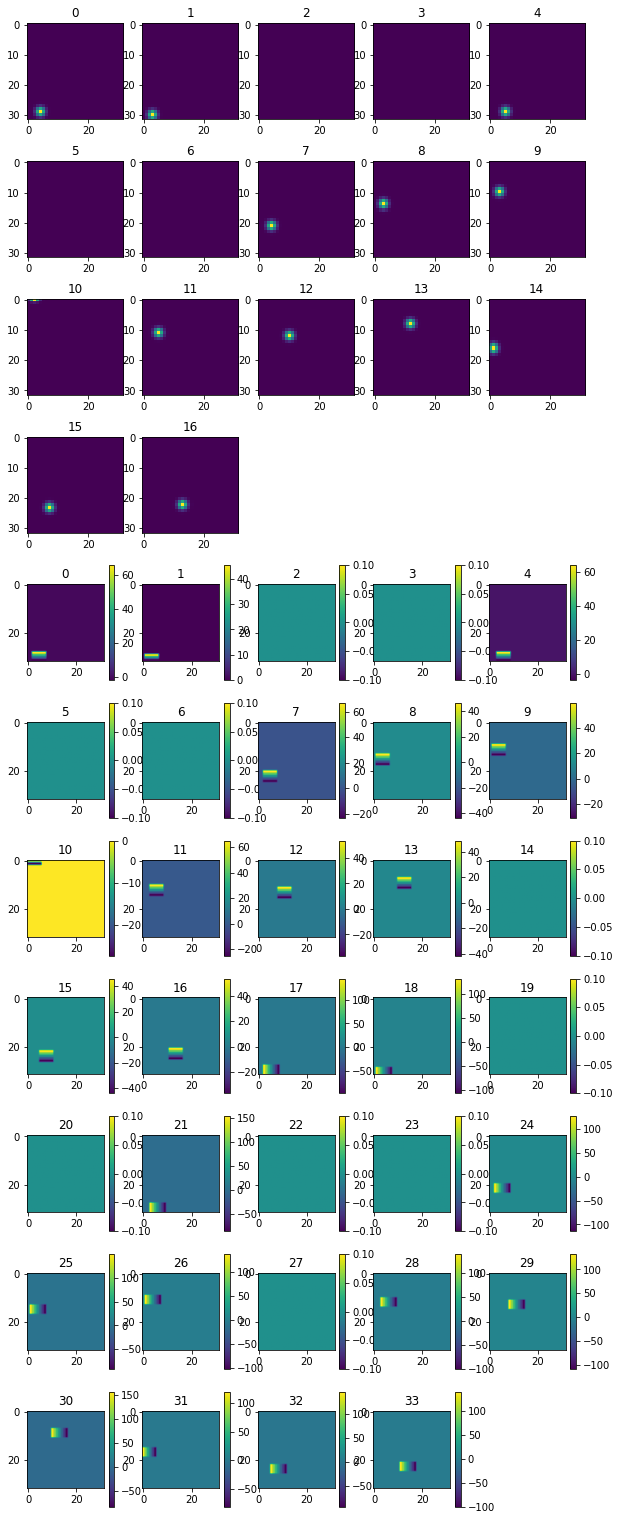

In [20]:
draw_heatmap(0, *regr)

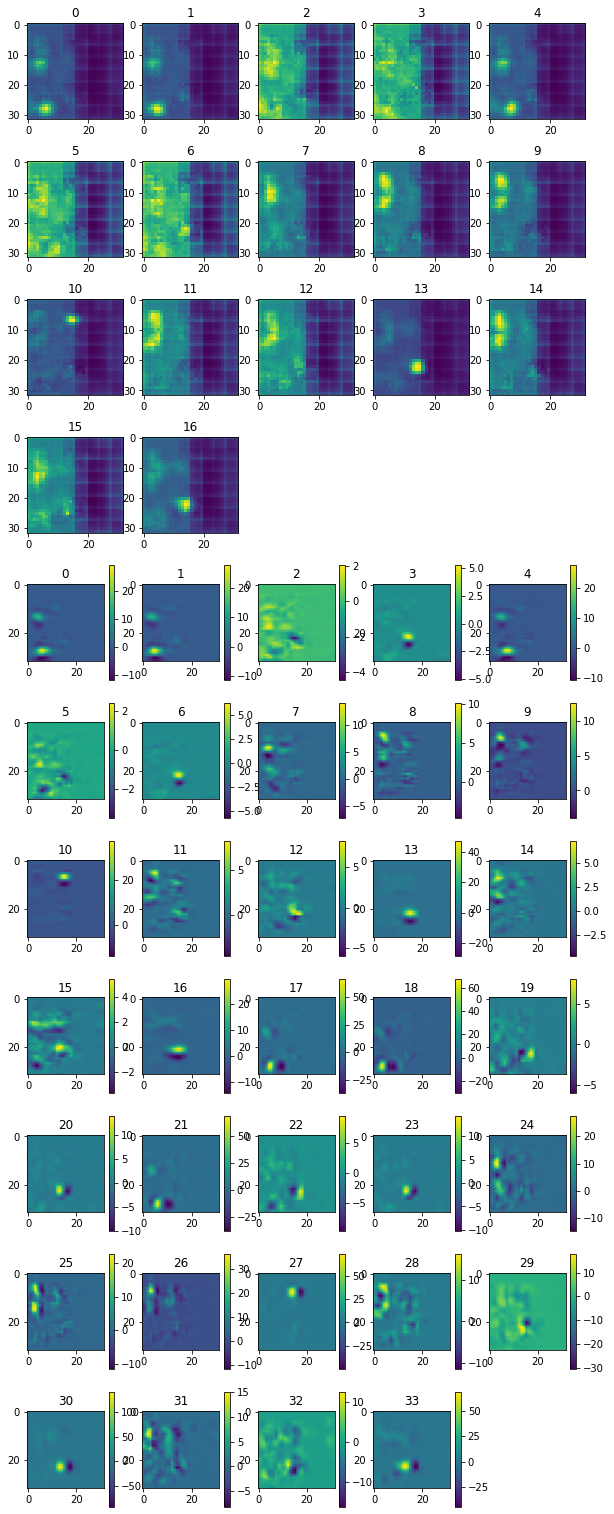

In [21]:
draw_heatmap(0, heatmap_result=result[0], offset_result=result[1])